# Alloy temperature prediction

In order to optimize production costs, the smelter decided to reduce electricity consumption during the steel processing stage. We need to build a model that will predict the steel temperature.

## Description of the production process

Steel is processed in a metal ladle with a capacity of about 100 tons. In order for the ladle to withstand high temperatures, it is lined with refractory bricks from the inside. Molten steel is poured into a ladle and heated to the desired temperature with graphite electrodes. They are installed in the lid of the bucket.
Sulfur is removed from the alloy (desulfurization), the chemical composition is corrected by adding impurities, and samples are taken. Steel is alloyed - its composition is changed - by feeding pieces of alloy from a bunker for bulk materials or wire through a special tribe apparatus.
Before introducing alloying additives for the first time, the temperature of the steel is measured and its chemical analysis is carried out. Then the temperature is raised for several minutes, alloying materials are added and the alloy is purged with an inert gas. Then it is stirred and measured again. This cycle is repeated until the target chemical composition and optimum melting temperature are reached.
Then the molten steel is sent to finish the metal or enters the continuous casting machine. From there, the finished product comes out in the form of slab blanks.

## Description of data

The data consists of files obtained from different sources:

- `data_arc.csv` — electrode data;
- `data_bulk.csv` - data on the supply of bulk materials (volume);
- `data_bulk_time.csv` *—* data on the supply of bulk materials (time);
- `data_gas.csv` — data on alloy gas purge;
- `data_temp.csv` - temperature measurement results;
- `data_wire.csv` - data on wire materials (volume);
- `data_wire_time.csv` - data on wire materials (time).

In all files, the `key` column contains the batch number. There can be several lines in files with the same `key` value: they correspond to different processing iterations.

## Approximate plan for solving the problem

1. Data exploration
2. Exploratory data analysis
3. Data preparation. Merging tables
4. Feature preparation
5. Checking features for multicollinearity
6. Splitting the dataset into training and test sets
7. Model creation. Hyperparameter fitting with cross-validation
8. Model testing
9. Analysis of the importance of features in the model
10. Checking the model for sanity

The project is made in **Jupyter Notebook**, Notebook server version: 6.4.6.
Version **Python** 3.10.1.
Libraries used in the project:
* **Pandas**
* **NumPy**
* **Seaborne**
* **MatPlotLib**
* **statsmodel**
* **scikit-learn**
* **IPython module**
* **Light GBM**

## 1. Data Exploration

In [1]:
# Import all the required modules and libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import time

In [2]:
# Read the datasets.
data_arc = pd.read_csv('data_arc.csv')
data_bulk = pd.read_csv('data_bulk.csv')
data_bulk_time = pd.read_csv('data_bulk_time.csv')
data_gas = pd.read_csv('data_gas.csv')
data_temp = pd.read_csv('data_temp.csv')
data_wire = pd.read_csv('data_wire.csv')
data_wire_time = pd.read_csv('data_wire_time.csv')

In [3]:
# Write a small function to view information.
def info(dataset):
    dataset.info()
    display(dataset)
# Make a list of the datasets.
datasets = [data_arc, data_bulk,
           data_bulk_time, data_gas,
           data_temp, data_wire, data_wire_time]
# Let's use the function.
for i in datasets:
    info(i)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Let's translate russian column headers to english.
data_arc.columns = [
    'key', 
    'start_of_arc_heating', 
    'end_of_arc_heating', 
    'active_power', 
    'reactive_power'
]
data_gas.columns = ['key', 'gas_1']
data_temp.columns = ['key', 'measurement_time', 'temperature']

Let's do some initial data analysis.

**data_arc**  
The table stores data on graphite electrodes used to heat molten steel by arc heating.
The *key* column indicates the batch number. The next two columns contain the date and time of the start and end of arc heating. Then the active and reactive power of the current used for heating.
  
*Suggestions for dataset processing*
* Check the dataset for row duplicates
* View unique values in the *key* column. You need to understand how many batches there were
* Check columns *Start of arc heating* and *End of arc heating* for duplicates. If there are, we may delete such rows
* It seems that we do not need the date and time of the start and end of arc heating. Let's get rid of them
* Check active and reactive power columns for outliers. Build range charts
* Group the data in the table by batch number and sum the power values. There is no physical meaning in the summation of time specific values in this case, but, in my opinion, the summation will make the signs more "accurate", more "capacious" for our future model. Will give her more undistorted information than the average value, which in the physical sense, of course, is more suitable

**data_bulk**  
The table stores data on the volume of bulk materials added to steel during alloying. We have 15 bulk materials in total. We do not know the names of the materials. We only see their numbers. For example, `Bulk 1`, `Bulk 2`, etc.

*Suggestions for dataset processing*
* Replace `NaN` values with zeros. In this case, `NaN` values means that this bulk material was not used in this batch.
* View unique values in the *key* column. It is necessary to understand how many batches there were.

**data_bulk_time**  
The table stores data on the time of supply of bulk materials added to steel during alloying. We have 15 bulk materials in total. We do not know the names of the materials. We only see their numbers. For example, `Bulk 1`, `Bulk 2`, etc.

*Suggestions for dataset processing*
* Replace `NaN`-values with 0
* Change the data type to DateTime

**data_gas**  
The table stores data on some parameter of the inert gas with which the alloy is blown.

*Suggestions for dataset processing*
* No `NaN`-values
* Check for full duplicates
* Check the column for outliers. Let's build a range diagram

**data_temp**  
The table stores data on the temperature of the alloy, the measurement time.

*Suggestions for dataset processing*
* Steel temperature of the last iteration of each batch is our target feature
* Check for row duplicates
* Check the column for outliers. Let's build a range diagram
* Change the data type of the *Sampling time* column to DateTime
* Let's look for patterns by which there are `NaN`-values in the data set. This will help us develop a strategy for handling them.

**data_wire**  
The table stores data on the volume of wire added to steel during alloying. In total we have 9 types of wire. The names of the wire are not known to us. We only see their numbers. For example, `Wire 1`, `Wire 2`, etc.

*Suggestions for dataset processing*
* Replace `NaN` with zeros. In this case, `NaN` means that this wire was not used in this batch.

**data_wire_time**  
The table stores data on the wire feed time added to the steel during alloying. In total we have 9 types of wire. The names of the wire are not known to us. We only see their numbers. For example, `Wire 1`, `Wire 2`, etc.

*Suggestions for dataset processing*
* Replace `NaN`-values with zeros
* Change the data type to DateTime

After doing an exploratory data analysis, we can combine the tables into one and start preparing the model.

## 2. Exploratory data analysis

**data_arc**

In [5]:
# Check for row duplicates.
print('Row duplicates number:', data_arc.duplicated().sum())

Row duplicates number: 0


In [6]:
# Look at the unique values in the key column.
# How many batches are there? Are there any missed ones?
unique_keys = data_arc['key'].value_counts().sort_index()
display(unique_keys)
print('Number of batches:', len(unique_keys))

1       5
2       4
3       5
4       4
5       4
       ..
3237    5
3238    3
3239    8
3240    5
3241    5
Name: key, Length: 3214, dtype: int64

Number of batches: 3214


Despite the last serial number 3241, we only have 3214 batches.

In [7]:
# Check for duplicates in temporary columns.
print('The number of duplicates in the column "Start of arc heating":', 
      data_arc['start_of_arc_heating'].duplicated().sum())
print('Number of duplicates in the column "End of arc heating":', 
      data_arc['end_of_arc_heating'].duplicated().sum())
# Define a row duplicate.
trfal = data_arc['start_of_arc_heating'].duplicated(keep=False)
print(trfal[trfal].index)
# Take a look at it.
display(data_arc.loc[[4872, 4876]])

The number of duplicates in the column "Start of arc heating": 1
Number of duplicates in the column "End of arc heating": 0
Int64Index([4872, 4876], dtype='int64')


,key,start_of_arc_heating,end_of_arc_heating,active_power,reactive_power
4872,1051,2019-06-10 22:02:03,2019-06-10 22:06:02,1.040376,0.635608
4876,1052,2019-06-10 22:02:03,2019-06-10 22:04:31,0.623495,0.508767


Strangely enough, in the column *start_of_arc_heating* we see two identical times (and dates) in two different batches. You can contact the customer and point out this fact for study with the telemetry department. We won't delete these rows because there is no duplicate data in the rest of the columns. So they are useful for the model.

In [8]:
# Get rid of the column with date and time data.
data_arc_upd = data_arc.copy()
data_arc_upd = data_arc_upd.drop(
    ['start_of_arc_heating', 'end_of_arc_heating'],
    axis=1
)
display(data_arc_upd)

,key,active_power,reactive_power
0,1,0.976059,0.687084
1,1,0.805607,0.520285
2,1,0.744363,0.498805
3,1,1.659363,1.062669
4,1,0.692755,0.414397
...,...,...,...
14871,3241,0.533670,0.354439
14872,3241,0.676604,0.523631
14873,3241,0.733899,0.475654
14874,3241,0.220694,0.145768


,active_power,reactive_power
count,14876.000000,14876.000000
mean,0.670441,0.452592
std,0.408159,5.878702
min,0.030002,-715.504924
25%,0.395297,0.290991
50%,0.555517,0.415962
75%,0.857034,0.637371
max,3.731596,2.676388


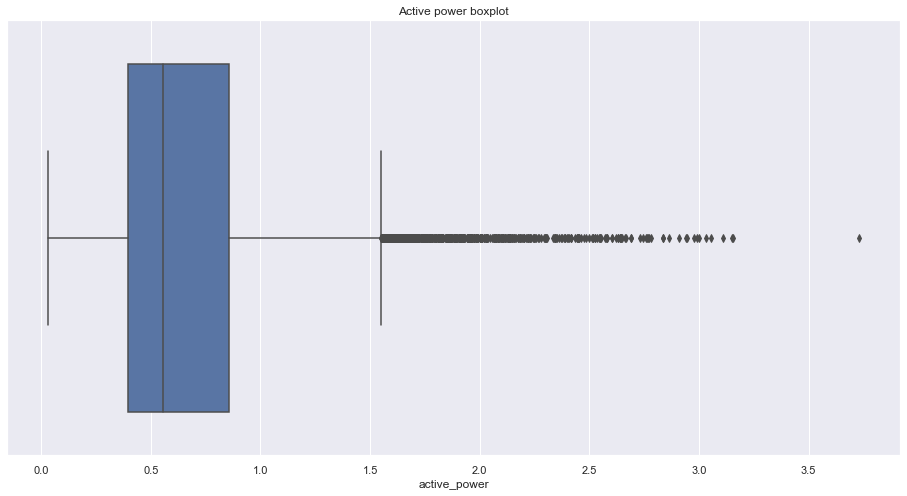

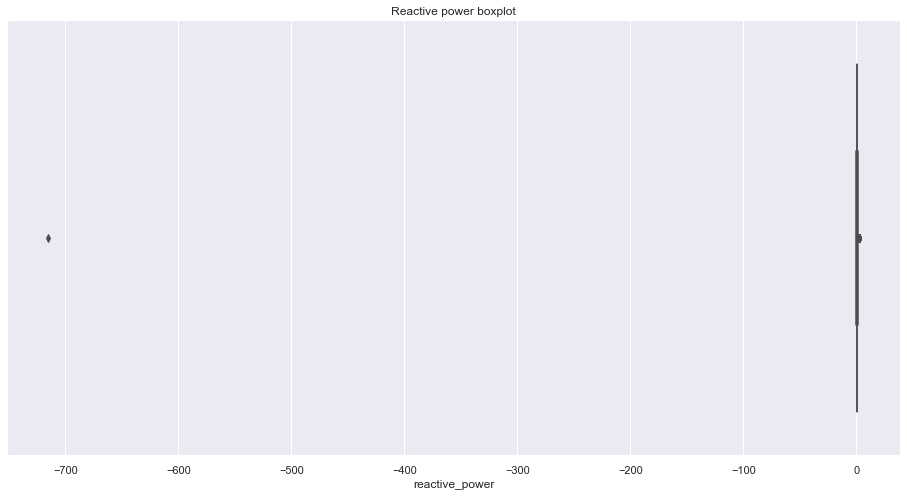

In [9]:
# Let's search for outliers.
display(
    data_arc_upd[['active_power','reactive_power']].describe()
)
sns.set(rc = {'figure.figsize':(16,8)})
sns.set_theme(style='darkgrid')
ax = sns.boxplot(x=data_arc_upd['active_power'])
plt.title('Active power boxplot')
plt.show()
ax = sns.boxplot(x=data_arc_upd['reactive_power'])
plt.title('Reactive power boxplot')
plt.show()

Theoretically, reactive power can be negative, but I guess this is not our case. Let's get rid of outliers (especially since there are few of them).

In [10]:
# Process outliers. Let's look at the lines first.
# Determine the indexes of the desired rows.
display(data_arc_upd['active_power'].sort_values())
display(data_arc_upd['reactive_power'].sort_values())
# Our indices are 7799 and 9780
display(data_arc_upd.loc[[ 7799, 9780]])
# Let's see what are the usual values of reactive power
# occur when the active power is approximately 0.495.
replacement_number_1_react = data_arc_upd.loc[
    (data_arc_upd['active_power'] >= 0.49) & 
    (data_arc_upd['active_power'] <= 0.495)]['reactive_power'].mean()
print('Valid value for overshoot replacement in reactive power column', 
      replacement_number_1_react)
# Let's see what are the usual active power values
# occur when the reactive power is approximately 2.676.
display(data_arc_upd.loc[[13760, 12424, 9361, 9226, 7799]])
# We can easily replace with any close number. For example, 3.17.
replacement_number_2_act = 3.17
print('Valid value to replace surge in active power column', 
      replacement_number_2_act)
# Let's make replacements.
data_arc_upd.loc[7799, 'active_power'] = replacement_number_2_act
data_arc_upd.loc[9780, 'reactive_power'] = replacement_number_1_react

7372     0.030002
5596     0.030188
5320     0.030190
2419     0.030563
4914     0.031630
           ...   
14200    3.052813
9870     3.107820
12424    3.150762
9226     3.156276
7799     3.731596
Name: active_power, Length: 14876, dtype: float64

9780    -715.504924
5596       0.020806
2419       0.021154
4914       0.022485
4633       0.022983
            ...    
13760      2.335088
12424      2.397032
9361       2.459959
9226       2.504206
7799       2.676388
Name: reactive_power, Length: 14876, dtype: float64

,key,active_power,reactive_power
7799,1689,3.731596,2.676388
9780,2116,0.495782,-715.504924


Valid value for overshoot replacement in reactive power column 0.3706478644020619


,key,active_power,reactive_power
13760,2985,2.779279,2.335088
12424,2701,3.150762,2.397032
9361,2029,2.019395,2.459959
9226,2001,3.156276,2.504206
7799,1689,3.731596,2.676388


Valid value to replace surge in active power column 3.17


,active_power,reactive_power
count,14876.000000,14876.000000
mean,0.670404,0.500715
std,0.407902,0.310872
min,0.030002,0.020806
25%,0.395297,0.291008
50%,0.555517,0.415962
75%,0.857034,0.637371
max,3.170000,2.676388


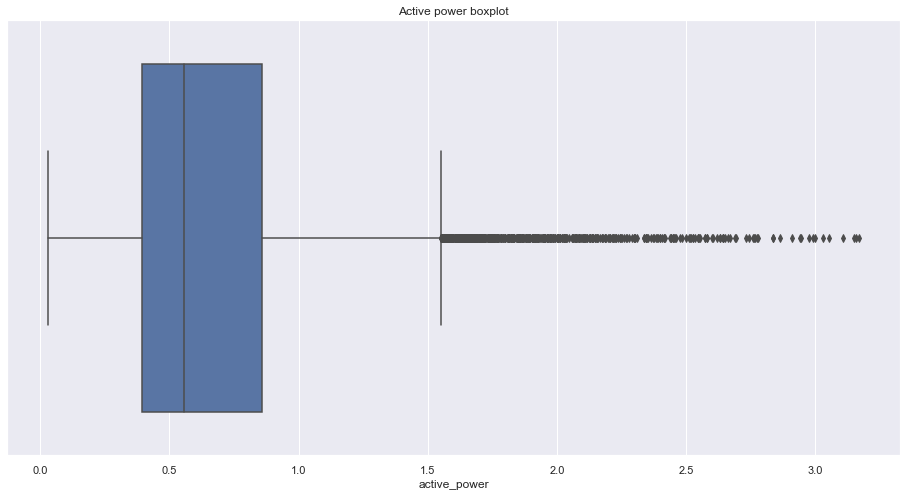

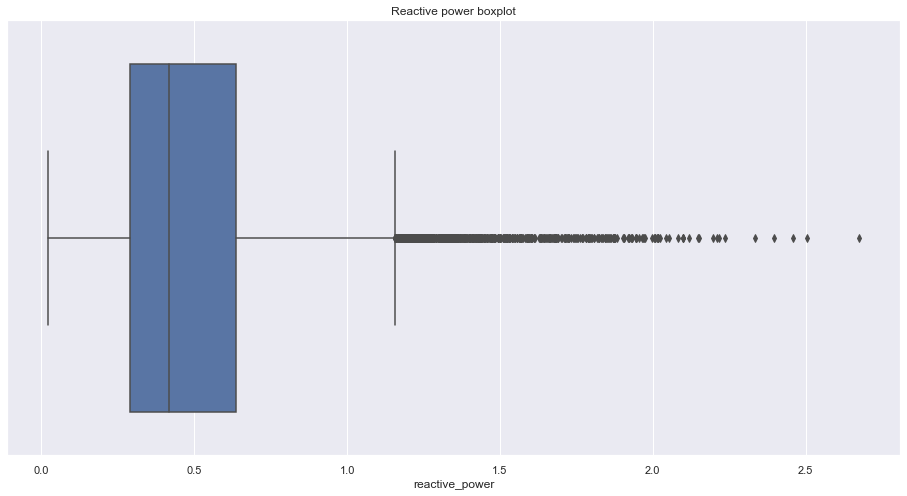

In [11]:
# Let's check the outliers again.
display(
    data_arc_upd[['active_power','reactive_power']].describe()
)
ax = sns.boxplot(x=data_arc_upd['active_power'])
plt.title('Active power boxplot')
plt.show()
ax = sns.boxplot(x=data_arc_upd['reactive_power'])
plt.title('Reactive power boxplot')
plt.show()

In [12]:
# Let's group by the batches.
data_arc_grouped = data_arc_upd.pivot_table(
    index='key', 
    values=['active_power', 'reactive_power'], 
    aggfunc='sum'
)
display(data_arc_grouped)

,active_power,reactive_power
key,,
1,4.878147,3.183241
2,3.052598,1.998112
3,2.525882,1.599076
4,3.209250,2.060298
5,3.347173,2.252643
...,...,...
3237,3.932467,2.828459
3238,2.106529,1.681182
3239,4.666754,3.111617


**data_bulk**

In [13]:
# Let's replace NaN-values.
data_bulk_upd = data_bulk.copy()
data_bulk_upd = data_bulk_upd.fillna(0)
display(data_bulk_upd)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


In [14]:
# Let's check for row duplicates.
print('Row duplicates number', data_bulk.duplicated().sum())

Row duplicates number 0


In [15]:
# Examine data for obvious anomalies.
display(data_bulk_upd.drop(['key'], axis=1).describe())

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Strange, incredibly large or negative values of the volumes of added impurities were not found. In this case, it is recommended to consult with the customer, having found out the range of permissible values for the volume of added substances.

In [16]:
# Look at the unique values in the key column.
# How many batches are there? Are there any missed ones?
unique_keys = data_bulk_upd['key'].value_counts().sort_index()
display(unique_keys)
print('Number of batches is', len(unique_keys))

1       1
2       1
3       1
4       1
5       1
       ..
3237    1
3238    1
3239    1
3240    1
3241    1
Name: key, Length: 3129, dtype: int64

Number of batches is 3129


This table also has less than 3241 rows. We must be careful when joining tables.

**data_bulk_time** 

In [17]:
# Change the date and time format to DateTime.
data_bulk_time_upd = data_bulk_time.copy()
data_bulk_time_upd.loc[
    :,data_bulk_time_upd.columns != 'key'] = data_bulk_time_upd.loc[
    :, data_bulk_time_upd.columns != 'key'].apply(pd.to_datetime)
display(data_bulk_time_upd)
data_bulk_time_upd.info()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaT,NaT,2019-08-31 22:51:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 22:46:52,NaT,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaT,NaT,2019-08-31 23:39:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 23:33:09,NaT,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:51:58,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:39:41,NaT,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaT,NaT,NaT,NaT,NaT,2019-09-01 03:12:40,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-01 02:41:27,2019-09-01 02:41:27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


**data_gas** 

In [18]:
# Check for row duplicates.
print('Number of row duplicates is', data_gas.duplicated().sum())

Number of row duplicates is 0


count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas_1, dtype: float64

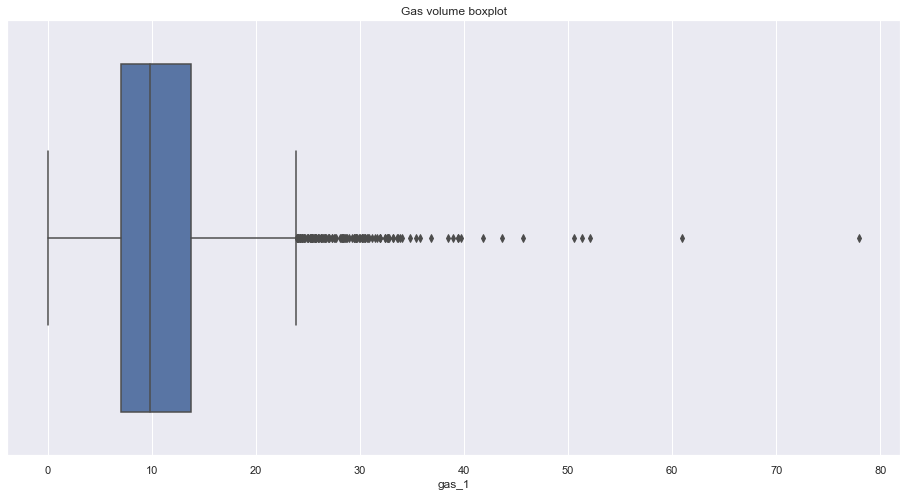

In [19]:
# Plot the boxplot.
display(data_gas['gas_1'].describe())
ax = sns.boxplot(x=data_gas['gas_1'])
plt.title('Gas volume boxplot')
plt.show()

In [20]:
# Define the potential outlier key.
display(data_gas.sort_values(by='gas_1').tail(10))
# Let's look at the number of iterations.
display(data_arc_upd.loc[data_arc_upd['key'] == 322])
# There are 13 of them.
# Group the data_arc_upd table and calculate
# how many iterations each batch has.
data_arc_grouped_2 = data_arc_upd.pivot_table(
    index='key', 
    values=['active_power'], 
    aggfunc='count'
)
display(data_arc_grouped_2['active_power'].sort_values())

,key,gas_1
610,613,39.425706
525,528,39.728826
660,663,41.854643
1461,1464,43.655411
2105,2108,45.638999
116,117,50.581035
2567,2570,51.380229
2107,2110,52.142373
277,280,60.935689
319,322,77.995040


,key,active_power,reactive_power
1487,322,0.518544,0.382905
1488,322,0.801966,0.582975
1489,322,1.019583,0.815634
1490,322,0.294657,0.212946
1491,322,0.451133,0.363475
1492,322,1.247301,0.979751
1493,322,0.405259,0.317796
1494,322,0.707713,0.559410
1495,322,0.407723,0.321421
1496,322,0.309299,0.375072


key
943      1
2582     1
246      1
343      1
1914     1
        ..
322     13
2567    14
1689    15
1513    15
2108    16
Name: active_power, Length: 3214, dtype: int64

We see that most likely the more iterations, the more inert gas was consumed. Let's not consider 77.995040 and values close to it as an outlier.

**data_temp** 

In [21]:
# Change the format of the Sample Time column to DateTime.
data_temp_upd = data_temp.copy()
data_temp_upd['measurement_time'] = pd.to_datetime(data_temp_upd['measurement_time'])
data_temp_upd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               15907 non-null  int64         
 1   measurement_time  15907 non-null  datetime64[ns]
 2   temperature       13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


The **data_temp** table has many missing values in the *Temperature* column. It is impossible to replace these missing values correctly. We will have to get rid of rows with missing values, as they will affect the quality of the model.

In [22]:
# Deleting the missing values.
data_temp_upd = data_temp_upd.dropna()
data_temp_upd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               13006 non-null  int64         
 1   measurement_time  13006 non-null  datetime64[ns]
 2   temperature       13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 406.4 KB


In [23]:
# Check for row duplicates.
print('Number of row duplicates is', data_temp_upd.duplicated().sum())

Number of row duplicates is 0


count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: temperature, dtype: float64

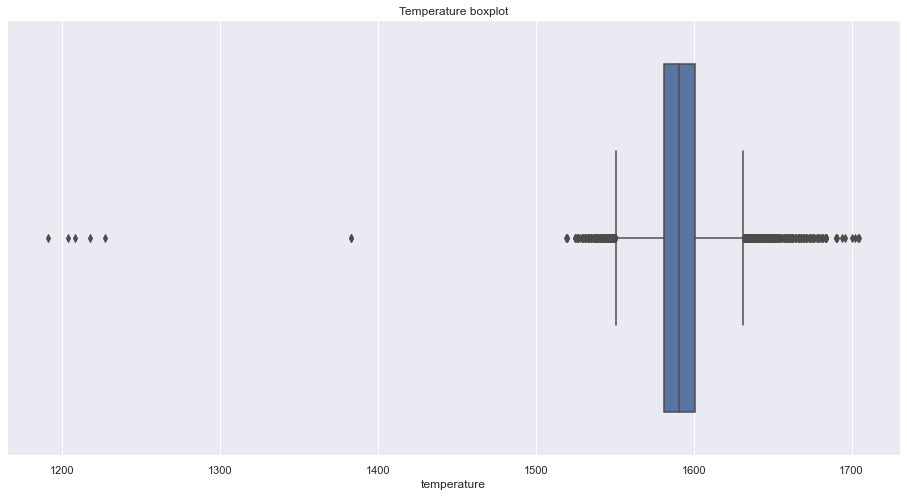

In [24]:
# Search for outliers.
display(data_temp_upd['temperature'].describe())
ax = sns.boxplot(x=data_temp_upd['temperature'])
plt.title('Temperature boxplot')
plt.show()

According to the condition of our task, the steel is poured into the ladle in an already molten state. Given that the melting temperature of steel can range from 1300 &#176;C to +/- 1500 &#176;C, values below 1300 &#176;C are clearly outliers. Let's delete them. The only value is greater than 1300 &#176;C, but we will also remove less than 1400 &#176;C to improve the quality of the future model.

count    12999.000000
mean      1592.020078
std         19.853665
min       1519.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: temperature, dtype: float64

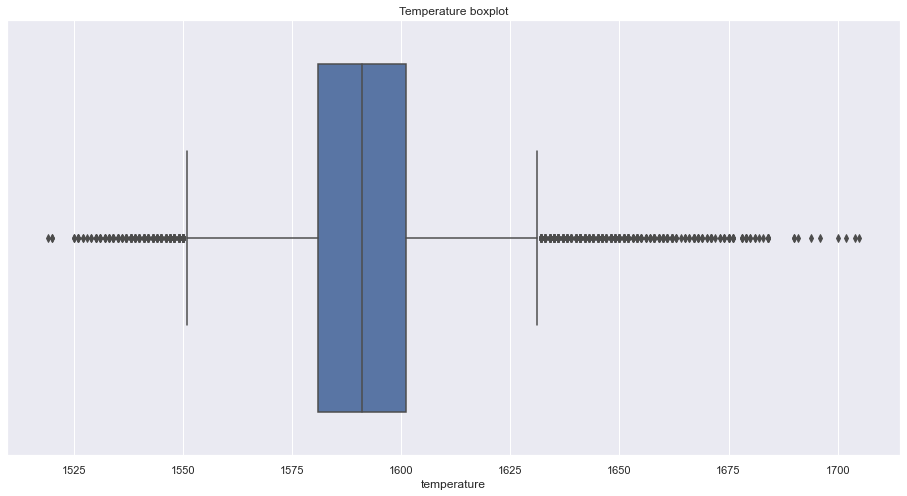

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12999 entries, 0 to 12998
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               12999 non-null  int64         
 1   measurement_time  12999 non-null  datetime64[ns]
 2   temperature       12999 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 304.8 KB


,key,measurement_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12994,3237,2019-08-31 22:44:04,1569.0
12995,3238,2019-08-31 23:30:31,1584.0
12996,3239,2019-09-01 01:31:47,1598.0
12997,3240,2019-09-01 02:39:01,1617.0


In [25]:
# Remove outliers to improve the future model.
data_temp_upd = data_temp_upd.loc[data_temp_upd['temperature'] > 1400].reset_index(drop=True)
display(data_temp_upd['temperature'].describe())
ax = sns.boxplot(x=data_temp_upd['temperature'])
plt.title('Temperature boxplot')
plt.show()
data_temp_upd.info()
display(data_temp_upd)

**data_wire**

In [26]:
# Let's replace missing values.
data_wire_upd = data_wire.copy()
data_wire_upd = data_wire_upd.fillna(0)
display(data_wire_upd)
data_wire_upd.info()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [27]:
# Check for row duplicates.
print('Number of row duplicates is', data_wire_upd.duplicated().sum())

Number of row duplicates is 0


In [28]:
# Examine the data for obvious anomalies.
display(data_wire_upd.drop(['key'], axis=1).describe())

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


Strange, incredibly large or negative values of the added wire volumes were not found. In this case, it is recommended to consult with the customer, having found out the range of permissible values for the volume of added wire.

**data_wire_time**

In [29]:
# Change the data format to DateTime.
data_wire_time_upd = data_wire_time.copy()
data_wire_time_upd.loc[
    :,data_wire_time_upd.columns != 'key'] = data_wire_time_upd.loc[
    :, data_wire_time_upd.columns != 'key'].apply(pd.to_datetime)
display(data_wire_time_upd)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3077,3238,2019-08-31 23:38:24,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3078,3239,2019-09-01 01:50:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3079,3240,2019-09-01 03:12:02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


## 3. Data preparing. Merging the tables.

Let's merge all tables containing date and time. Let's determine the parties in which the operation of measuring the temperature was the last.

In [30]:
# Merge all tables containing date and time.
final = pd.merge(data_temp_upd, data_bulk_time_upd, how='outer', on='key')
final_2 = pd.merge(final, data_wire_time_upd, how='outer', on='key')
# Immediately delete the row with the NaT value in the "measurement_ime" column.
final_2 = final_2.drop(12999, axis=0)
final_2 = final_2.drop(['key', 'temperature'], axis=1)
display(final_2)
final_2.info()

,measurement_time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,2019-05-03 11:16:18,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2019-05-03 11:25:53,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,2019-05-03 11:29:11,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,2019-05-03 11:30:01,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,2019-05-03 11:30:39,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12994,2019-08-31 22:44:04,NaT,NaT,2019-08-31 22:51:28,NaT,NaT,NaT,NaT,NaT,NaT,...,2019-08-31 22:46:52,2019-08-31 22:50:20,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
12995,2019-08-31 23:30:31,NaT,NaT,2019-08-31 23:39:11,NaT,NaT,NaT,NaT,NaT,NaT,...,2019-08-31 23:33:09,2019-08-31 23:38:24,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
12996,2019-09-01 01:31:47,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:51:58,NaT,NaT,NaT,...,2019-09-01 01:33:25,2019-09-01 01:50:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
12997,2019-09-01 02:39:01,NaT,NaT,NaT,NaT,NaT,2019-09-01 03:12:40,NaT,NaT,NaT,...,2019-09-01 02:41:27,2019-09-01 03:12:02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12999 entries, 0 to 12998
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   measurement_time  12999 non-null  datetime64[ns]
 1   Bulk 1            1154 non-null   datetime64[ns]
 2   Bulk 2            120 non-null    datetime64[ns]
 3   Bulk 3            5124 non-null   datetime64[ns]
 4   Bulk 4            4277 non-null   datetime64[ns]
 5   Bulk 5            354 non-null    datetime64[ns]
 6   Bulk 6            2443 non-null   datetime64[ns]
 7   Bulk 7            125 non-null    datetime64[ns]
 8   Bulk 8            4 non-null      datetime64[ns]
 9   Bulk 9            64 non-null     datetime64[ns]
 10  Bulk 10           730 non-null    datetime64[ns]
 11  Bulk 11           707 non-null    datetime64[ns]
 12  Bulk 12           9872 non-null   datetime64[ns]
 13  Bulk 13           106 non-null    datetime64[ns]
 14  Bulk 14           1123

In [31]:
# All temporary data in DateTime format. So they can be compared.
# Detect the lines in which the last time the temperature was measured.
max_value = final_2.idxmax(axis=1)
print('The operation that was performed last in this iteration:')
display(max_value)
# Get the indices of those rows where we have the value "measurement_time".
idx = max_value.index[max_value == 'measurement_time']
display(idx)

The operation that was performed last in this iteration:


0                  Bulk 4
1        measurement_time
2        measurement_time
3        measurement_time
4        measurement_time
               ...       
12994              Bulk 3
12995              Bulk 3
12996              Bulk 6
12997              Bulk 6
12998              Wire 1
Length: 12999, dtype: object

Int64Index([    1,     2,     3,     4,     7,     8,     9,    10,    15,
               16,
            ...
            12590, 12622, 12666, 12667, 12706, 12781, 12822, 12945, 12956,
            12985],
           dtype='int64', length=7624)

In [32]:
# Back to the data_temp_upd table.
# Display the data with the previously selected indices.
data_temp_prefinal = data_temp_upd.loc[idx]
display(data_temp_prefinal)

,key,measurement_time,temperature
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
7,2,2019-05-03 11:49:38,1589.0
...,...,...,...
12781,3022,2019-08-25 01:02:08,1583.0
12822,3063,2019-08-26 11:41:46,1563.0
12945,3186,2019-08-30 09:45:52,1591.0
12956,3197,2019-08-30 18:56:00,1580.0


In [33]:
# Now we need to remove all lines of each batch,
# except for the last iteration.
data_temp_final = (
    data_temp_prefinal.sort_values(
        'measurement_time').groupby('key').tail(1).drop(
        ['measurement_time'], axis=1
    )
)
display(data_temp_final)
data_temp_final.info()

,key,temperature
4,1,1613.0
10,2,1602.0
15,3,1599.0
18,4,1625.0
20,5,1602.0
...,...,...
12781,3022,1583.0
12822,3063,1563.0
12945,3186,1591.0
12956,3197,1580.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2482 entries, 4 to 12985
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          2482 non-null   int64  
 1   temperature  2482 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 58.2 KB


In [34]:
# Let's keep the original temperatures.
# This feature will be useful in modeling.
data_temp_first = (
    data_temp_upd.sort_values('measurement_time').groupby('key').head(1).drop(
        ['measurement_time'], 
        axis=1
    )
)
display(data_temp_first)
data_temp_first.info()

,key,temperature
0,1,1571.0
5,2,1581.0
11,3,1596.0
16,4,1601.0
19,5,1576.0
...,...,...
12994,3237,1569.0
12995,3238,1584.0
12996,3239,1598.0
12997,3240,1617.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3215 entries, 0 to 12998
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          3215 non-null   int64  
 1   temperature  3215 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 75.4 KB


Now let's combine the data into a table that will serve as our base for modeling.
We need to join the following tables by the key *key*:
* data_temp_final
* data_temp_first
* data_arc_grouped
* data_bulk_upd
* data_gas
* data_wire

In [35]:
# Merging the tables.
pre_data_1 = pd.merge(data_temp_final, data_temp_first, how='left', on='key')
pre_data_2 = pd.merge(pre_data_1, data_arc_grouped, how='left', on='key')
pre_data_3 = pd.merge(pre_data_2, data_bulk_upd, how='left', on='key')
pre_data_4 = pd.merge(pre_data_3, data_gas, how='left', on='key')
pre_data_5 = pd.merge(pre_data_4, data_wire, how='left', on='key')
pre_data_5 = pre_data_5.rename(
    columns={'temperature_x': 'final_temperature',
             'temperature_y': 'initial_temperature'}
)
display(pre_data_5)
pre_data_5.info()

,key,final_temperature,initial_temperature,active_power,reactive_power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,gas_1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1613.0,1571.0,4.878147,3.183241,0.0,0.0,0.0,43.0,0.0,...,29.749986,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1602.0,1581.0,3.052598,1.998112,0.0,0.0,0.0,73.0,0.0,...,12.555561,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1599.0,1596.0,2.525882,1.599076,0.0,0.0,0.0,34.0,0.0,...,28.554793,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1625.0,1601.0,3.209250,2.060298,0.0,0.0,0.0,81.0,0.0,...,18.841219,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1602.0,1576.0,3.347173,2.252643,0.0,0.0,0.0,78.0,0.0,...,5.413692,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,3022,1583.0,1583.0,3.110264,2.444044,0.0,0.0,0.0,0.0,0.0,...,9.552213,112.170234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2478,3063,1563.0,1563.0,4.436722,3.194935,0.0,0.0,58.0,0.0,0.0,...,8.373330,109.199997,76.153999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2479,3186,1591.0,1591.0,2.456302,1.857677,0.0,0.0,140.0,0.0,0.0,...,5.699542,130.166403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2480,3197,1580.0,1580.0,1.788605,1.335075,0.0,0.0,154.0,0.0,0.0,...,1.837179,30.008158,90.178398,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2482 entries, 0 to 2481
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2482 non-null   int64  
 1   final_temperature    2482 non-null   float64
 2   initial_temperature  2482 non-null   float64
 3   active_power         2480 non-null   float64
 4   reactive_power       2480 non-null   float64
 5   Bulk 1               2409 non-null   float64
 6   Bulk 2               2409 non-null   float64
 7   Bulk 3               2409 non-null   float64
 8   Bulk 4               2409 non-null   float64
 9   Bulk 5               2409 non-null   float64
 10  Bulk 6               2409 non-null   float64
 11  Bulk 7               2409 non-null   float64
 12  Bulk 8               2409 non-null   float64
 13  Bulk 9               2409 non-null   float64
 14  Bulk 10              2409 non-null   float64
 15  Bulk 11              2409 non-null   f

In [36]:
# The Wire 5 column can be removed.
# Also remove the lines where active and reactive power, gas are skipped.
# Replace other missing values with 0.
pre_data_6 = pre_data_5.drop(['Wire 5'], axis=1)
pre_data_7 = pre_data_6.dropna(
    subset=['active_power', 'reactive_power', 'gas_1']
)
data = pre_data_7.fillna(0).drop(['key'], axis=1).reset_index(drop=True)
data.info()
display(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   final_temperature    2478 non-null   float64
 1   initial_temperature  2478 non-null   float64
 2   active_power         2478 non-null   float64
 3   reactive_power       2478 non-null   float64
 4   Bulk 1               2478 non-null   float64
 5   Bulk 2               2478 non-null   float64
 6   Bulk 3               2478 non-null   float64
 7   Bulk 4               2478 non-null   float64
 8   Bulk 5               2478 non-null   float64
 9   Bulk 6               2478 non-null   float64
 10  Bulk 7               2478 non-null   float64
 11  Bulk 8               2478 non-null   float64
 12  Bulk 9               2478 non-null   float64
 13  Bulk 10              2478 non-null   float64
 14  Bulk 11              2478 non-null   float64
 15  Bulk 12              2478 non-null   f

,final_temperature,initial_temperature,active_power,reactive_power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Bulk 15,gas_1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1613.0,1571.0,4.878147,3.183241,0.0,0.0,0.0,43.0,0.0,0.0,...,154.0,29.749986,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1602.0,1581.0,3.052598,1.998112,0.0,0.0,0.0,73.0,0.0,0.0,...,154.0,12.555561,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,1599.0,1596.0,2.525882,1.599076,0.0,0.0,0.0,34.0,0.0,0.0,...,153.0,28.554793,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,1625.0,1601.0,3.209250,2.060298,0.0,0.0,0.0,81.0,0.0,0.0,...,154.0,18.841219,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,1602.0,1576.0,3.347173,2.252643,0.0,0.0,0.0,78.0,0.0,0.0,...,152.0,5.413692,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,1583.0,1583.0,3.110264,2.444044,0.0,0.0,0.0,0.0,0.0,0.0,...,258.0,9.552213,112.170234,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2474,1563.0,1563.0,4.436722,3.194935,0.0,0.0,58.0,0.0,0.0,156.0,...,206.0,8.373330,109.199997,76.153999,0.0,0.0,0.0,0.0,0.0,0.0
2475,1591.0,1591.0,2.456302,1.857677,0.0,0.0,140.0,0.0,0.0,0.0,...,106.0,5.699542,130.166403,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2476,1580.0,1580.0,1.788605,1.335075,0.0,0.0,154.0,0.0,0.0,0.0,...,206.0,1.837179,30.008158,90.178398,0.0,0.0,0.0,0.0,0.0,0.0


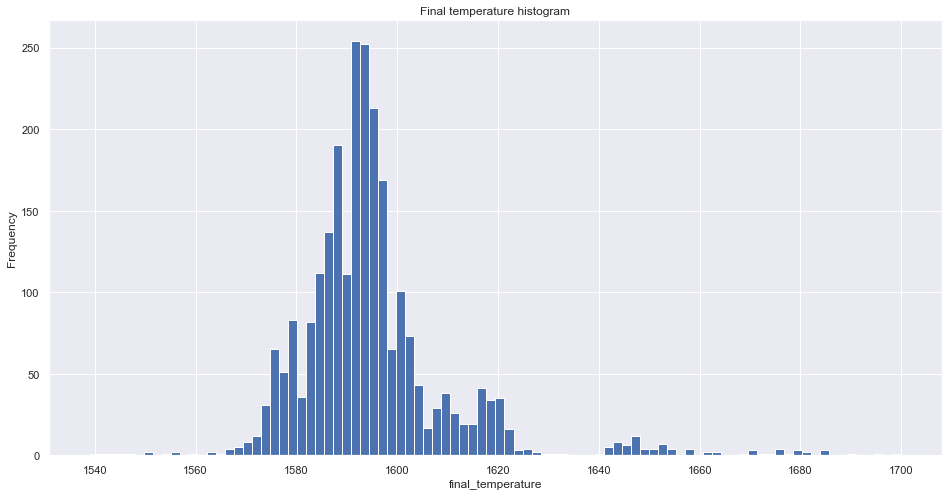

In [37]:
# Let's look at the distribution of values
# our future target feature is the final temperature.
data['final_temperature'].hist(bins=90)
plt.xlabel('final_temperature')
plt.ylabel('Frequency')
plt.title('Final temperature histogram')
plt.show()

Note that up to 1570 &#176;C and between 1625 &#176;C and 1690 &#176;C there are outliers. We understand that they correspond in real life - such temperatures have become quite possible in the liquid state. But in order to achieve the required level of the metric of the future model, we will delete the rows with these values. Of course, such actions will need to be coordinated with the customer. If the business does not agree on our proposal, then it is necessary to consider increasing the level of the target value of the MAE metric.

In [38]:
# Get rid of rows with outliers.
data = data.loc[(data['final_temperature'] > 1570) & (data['final_temperature'] < 1625)]

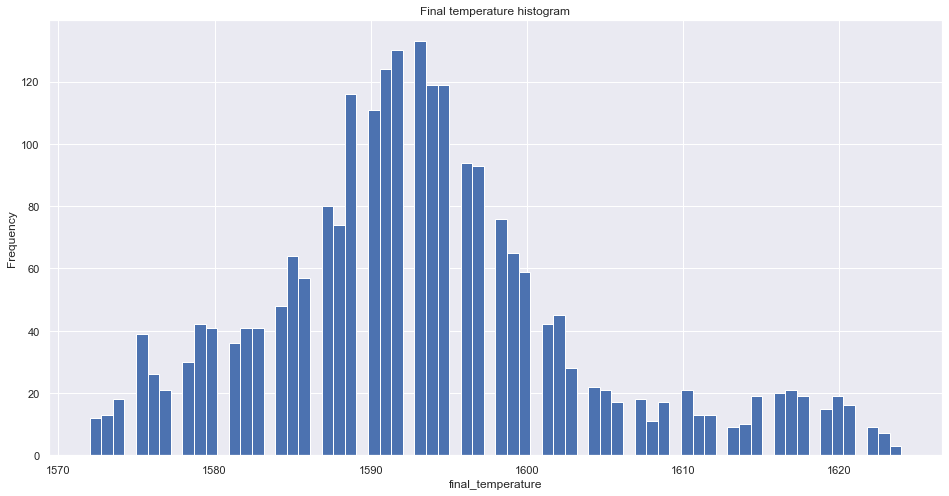

In [39]:
# Let's look at the distribution of values
# temperatures after deleting rows.
data['final_temperature'].hist(bins=70)
plt.xlabel('final_temperature')
plt.ylabel('Frequency')
plt.title('Final temperature histogram')
plt.show()

We have completed exploratory data analysis and preparation for use in model development.

## 4. Features preparing

In [40]:
# Take a look at our dataset once again.
display(data)
data.info()

,final_temperature,initial_temperature,active_power,reactive_power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Bulk 15,gas_1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1613.0,1571.0,4.878147,3.183241,0.0,0.0,0.0,43.0,0.0,0.0,...,154.0,29.749986,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1602.0,1581.0,3.052598,1.998112,0.0,0.0,0.0,73.0,0.0,0.0,...,154.0,12.555561,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,1599.0,1596.0,2.525882,1.599076,0.0,0.0,0.0,34.0,0.0,0.0,...,153.0,28.554793,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,1602.0,1576.0,3.347173,2.252643,0.0,0.0,0.0,78.0,0.0,0.0,...,152.0,5.413692,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0
5,1596.0,1543.0,3.955108,2.689175,0.0,0.0,0.0,117.0,0.0,0.0,...,154.0,11.273392,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,1585.0,1585.0,2.209312,1.528631,0.0,0.0,0.0,0.0,0.0,0.0,...,206.0,7.562851,108.282722,30.461601,0.0,0.0,0.0,0.0,0.0,0.0
2473,1583.0,1583.0,3.110264,2.444044,0.0,0.0,0.0,0.0,0.0,0.0,...,258.0,9.552213,112.170234,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2475,1591.0,1591.0,2.456302,1.857677,0.0,0.0,140.0,0.0,0.0,0.0,...,106.0,5.699542,130.166403,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2476,1580.0,1580.0,1.788605,1.335075,0.0,0.0,154.0,0.0,0.0,0.0,...,206.0,1.837179,30.008158,90.178398,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2357 entries, 0 to 2477
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   final_temperature    2357 non-null   float64
 1   initial_temperature  2357 non-null   float64
 2   active_power         2357 non-null   float64
 3   reactive_power       2357 non-null   float64
 4   Bulk 1               2357 non-null   float64
 5   Bulk 2               2357 non-null   float64
 6   Bulk 3               2357 non-null   float64
 7   Bulk 4               2357 non-null   float64
 8   Bulk 5               2357 non-null   float64
 9   Bulk 6               2357 non-null   float64
 10  Bulk 7               2357 non-null   float64
 11  Bulk 8               2357 non-null   float64
 12  Bulk 9               2357 non-null   float64
 13  Bulk 10              2357 non-null   float64
 14  Bulk 11              2357 non-null   float64
 15  Bulk 12              2357 non-null   f

In [41]:
# Define the target feature.
features = data.drop(['final_temperature'], axis=1)
target = data['final_temperature']

## 5. Checking the features for multicollinearity

In [42]:
# Check the features for multicollinearity
# Create a function.
def vif(features):
    vif_dataset = pd.DataFrame()
    vif_dataset['feature_name'] = features.columns
    vif_dataset['VIF'] = [variance_inflation_factor(
            features.values, i) for i in range(features.shape[1])]
    
    return vif_dataset

In [43]:
# Let's calculate VIF.
vif(features)

/Users/pavelsuhih/.local/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,feature_name,VIF
0,initial_temperature,13.656492
1,active_power,84.680948
2,reactive_power,75.821376
3,Bulk 1,1.474075
4,Bulk 2,2.364667
5,Bulk 3,1.634709
6,Bulk 4,1.947899
7,Bulk 5,1.072516
8,Bulk 6,1.507037
9,Bulk 7,1.754402


The highest VIF was shown by *active_power*, *reactive_power*, *Bulk 9*, *Wire 8*, *initial_temperature*.
To begin with, we will process active and reactive power. Let's calculate the total power, add it to the column *electric_power*, and get rid of the columns *active_power* and *reactive_power*.

In [44]:
data['electric_power'] = (data['active_power']**2 + data['reactive_power']**2)**0.5
data = data.drop(['active_power', 'reactive_power'], axis=1)
display(data)

,final_temperature,initial_temperature,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,...,gas_1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,electric_power
0,1613.0,1571.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,29.749986,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,5.824889
1,1602.0,1581.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,12.555561,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.648398
2,1599.0,1596.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,28.554793,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.989502
4,1602.0,1576.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,5.413692,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,4.034596
5,1596.0,1543.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,...,11.273392,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,4.782734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,1585.0,1585.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.562851,108.282722,30.461601,0.0,0.0,0.0,0.0,0.0,0.0,2.686591
2473,1583.0,1583.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.552213,112.170234,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.955640
2475,1591.0,1591.0,0.0,0.0,140.0,0.0,0.0,0.0,0.0,0.0,...,5.699542,130.166403,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.079672
2476,1580.0,1580.0,0.0,0.0,154.0,0.0,0.0,0.0,0.0,0.0,...,1.837179,30.008158,90.178398,0.0,0.0,0.0,0.0,0.0,0.0,2.231935


In [45]:
# Let's update our features once again.
features = data.drop(['final_temperature'], axis=1)
# Calculate VIF.
vif(features)

/Users/pavelsuhih/.local/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,feature_name,VIF
0,initial_temperature,13.377256
1,Bulk 1,1.465256
2,Bulk 2,2.364634
3,Bulk 3,1.596298
4,Bulk 4,1.944212
5,Bulk 5,1.071933
6,Bulk 6,1.503781
7,Bulk 7,1.752761
8,Bulk 8,3.718105
9,Bulk 9,67.706270


Excellent! We managed to get rid of one feature with a high VIF value. Now we need to process *Bulk 9*, *Wire 8* features.

final_temperature      1.000000
initial_temperature    0.313705
Bulk 1                -0.031699
Bulk 2                 0.031862
Bulk 3                -0.041385
Bulk 4                 0.196867
Bulk 5                 0.013570
Bulk 6                -0.185623
Bulk 7                 0.044082
Bulk 8                -0.028597
Bulk 9                -0.017749
Bulk 10                0.064785
Bulk 11               -0.114714
Bulk 12                0.247457
Bulk 13               -0.001451
Bulk 14                0.094919
Bulk 15                0.254296
gas_1                  0.099060
Wire 1                 0.287929
Wire 2                -0.200577
Wire 3                -0.032296
Wire 4                 0.029140
Wire 6                -0.020588
Wire 7                      NaN
Wire 8                -0.012065
Wire 9                -0.040527
electric_power         0.290117
Name: final_temperature, dtype: float64

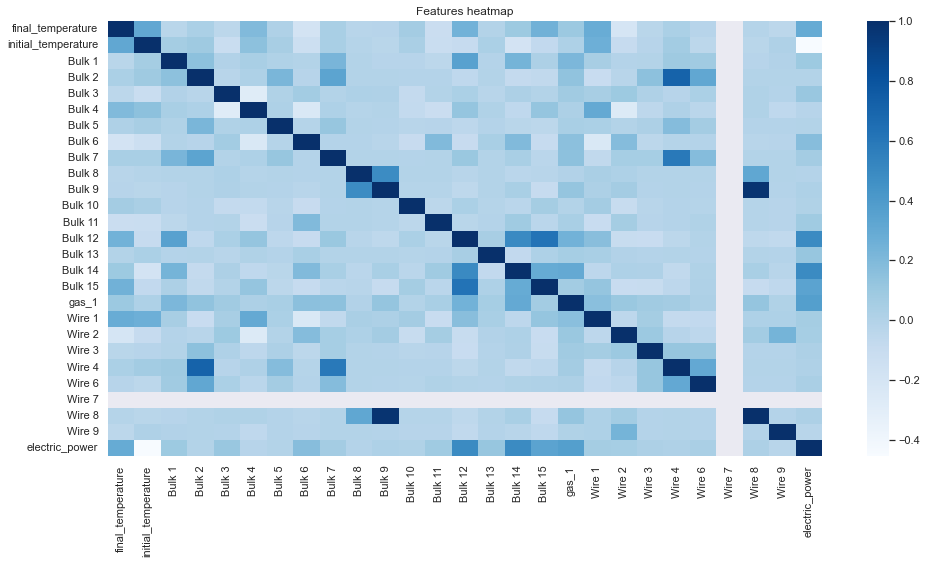

In [46]:
# Let's look at feature correlation.
display(data.corr().iloc[:,0])
sns.set(rc = {'figure.figsize':(16,8)})
sns.heatmap(data.corr(), cmap='Blues')
plt.title('Features heatmap')
plt.show()

We can see that *Bulk 9* and *Wire 8* features are approximately equally correlated with the target feature *Final Temperature*. But still *Wire 8* has less effect on the target feature. Let's add it with the sign *Wire 9*. Let's name the new column *Wire 8_9*.

In [47]:
# Adding the columns.
data['Wire 8_9'] = data['Wire 8'] + data['Wire 9']
# Deleting redundant columns.
data = data.drop(['Wire 8', 'Wire 9'], axis=1)
display(data)

,final_temperature,initial_temperature,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,...,Bulk 15,gas_1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,electric_power,Wire 8_9
0,1613.0,1571.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,154.0,29.749986,60.059998,0.000000,0.0,0.0,0.0,0.0,5.824889,0.0
1,1602.0,1581.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,154.0,12.555561,96.052315,0.000000,0.0,0.0,0.0,0.0,3.648398,0.0
2,1599.0,1596.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,153.0,28.554793,91.160157,0.000000,0.0,0.0,0.0,0.0,2.989502,0.0
4,1602.0,1576.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,152.0,5.413692,89.238236,9.114560,0.0,0.0,0.0,0.0,4.034596,0.0
5,1596.0,1543.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,...,154.0,11.273392,99.109917,9.114560,0.0,0.0,0.0,0.0,4.782734,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,1585.0,1585.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,206.0,7.562851,108.282722,30.461601,0.0,0.0,0.0,0.0,2.686591,0.0
2473,1583.0,1583.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,258.0,9.552213,112.170234,0.000000,0.0,0.0,0.0,0.0,3.955640,0.0
2475,1591.0,1591.0,0.0,0.0,140.0,0.0,0.0,0.0,0.0,0.0,...,106.0,5.699542,130.166403,0.000000,0.0,0.0,0.0,0.0,3.079672,0.0
2476,1580.0,1580.0,0.0,0.0,154.0,0.0,0.0,0.0,0.0,0.0,...,206.0,1.837179,30.008158,90.178398,0.0,0.0,0.0,0.0,2.231935,0.0


In [48]:
# Finally update features.
features = data.drop(['final_temperature'], axis=1)
# Calculate VIF.
vif(features)

/Users/pavelsuhih/.local/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,feature_name,VIF
0,initial_temperature,13.377026
1,Bulk 1,1.464501
2,Bulk 2,2.364632
3,Bulk 3,1.596298
4,Bulk 4,1.935211
5,Bulk 5,1.071898
6,Bulk 6,1.501612
7,Bulk 7,1.752692
8,Bulk 8,1.372459
9,Bulk 9,2.550128


In [49]:
# Let's review our datasets.
print('Dataset size', data.shape)
print('Feature set size', features.shape)
print('Target set size', target.shape)

Dataset size (2357, 26)
Feature set size (2357, 25)
Target set size (2357,)


We have achieved admissible limits of feature multicollinearity. Unfortunately, the initial temperature is quite strongly correlated with the total power, but we leave this feature due to its importance, due to its physical effect on the target feature. Let's start preparing the training and test sets.

## 6. Splitting the dataset into training and test sets

Let's split the dataset into 2 sets in a ratio of 3:1.

In [50]:
# Split the dataset into training and test sets.
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target, 
    test_size=.25,
    random_state=12345
)
# Check the sizes.   
set_names = ['features_train', 'target_train',
             'features_test', 'target_test']
samples = [features_train, target_train,
             features_test, target_test]
for name, kit in zip(set_names, samples):
    print('The size of the', name, 'column is', kit.shape)

The size of the features_train column is (1767, 25)
The size of the target_train column is (1767,)
The size of the features_test column is (590, 25)
The size of the target_test column is (590,)


We split our dataset into training and test sets. Let's start creating a model.

## 7. Model creation. Hyperparameter fitting with cross-validation

We will be building a gradient boosting model from Light GBM. Light GBM does a great job with regression tasks. We will use the gradient decision tree boosting.

**Gradient Boosting Light GBM**

In [51]:
%%time
# Create a gradient boosting model
# using the Light GBM library.
model_gb = lgb.LGBMRegressor(random_state=12345)
param_grid = {
    'boosting_type': ['gbdt'],
    'max_depth' : [2, 3, 4, 5, 6],
    'n_estimators' : [20, 50, 70, 100, 130, 150, 160],
    'learning_rate' : [0.001, 0.01, 0.05, 0.1],
    'num_leaves' : [10, 20, 30]
}
# Let's fit hyperparameters.
grid_cv_gb = GridSearchCV(estimator=model_gb, 
                          param_grid=param_grid, 
                          scoring='neg_mean_absolute_error',
                          cv=5,
                          n_jobs=-1)
grid_cv_gb.fit(features_train, target_train)
# Best parameters are.
best_parameters = grid_cv_gb.best_params_
print('Best parameters are\n', best_parameters)
# Best MAE is.
best_cv_gb_score = abs(grid_cv_gb.best_score_)
print(f'Best MAE is {best_cv_gb_score:.1f}')

Best parameters are
 {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 160, 'num_leaves': 10}
Best MAE is 5.9
CPU times: user 5.01 s, sys: 738 ms, total: 5.75 s
Wall time: 2min 24s


## 8. Model testing

Let's test the model.

In [52]:
# Create a model.
model_gb = lgb.LGBMRegressor(boosting_type='gbdt', 
                             random_state=12345,
                             max_depth=5,
                             learning_rate=0.05,
                             n_estimators=160,
                             num_leaves=10)
model_gb.fit(features_train, target_train)
# Make predictions.
predictions_gb = pd.Series(
    model_gb.predict(features_test), 
    index=target_test.index
    )
mae_gb = mean_absolute_error(target_test, predictions_gb)
print(f'MAE is {mae_gb:.1f}')

MAE is 5.5


## 9. Feature importances analysis

In [53]:
# Create a function for feature importances analysis.
def importance(model):
    importance = model.feature_importances_
    colums_features = features.columns 
    importance = pd.Series(importance, index=colums_features) 
    importance.sort_values(ascending=False).plot(
        kind='bar', 
        x=importance.index, 
        y=importance,
        title='Feature importances bar chart')

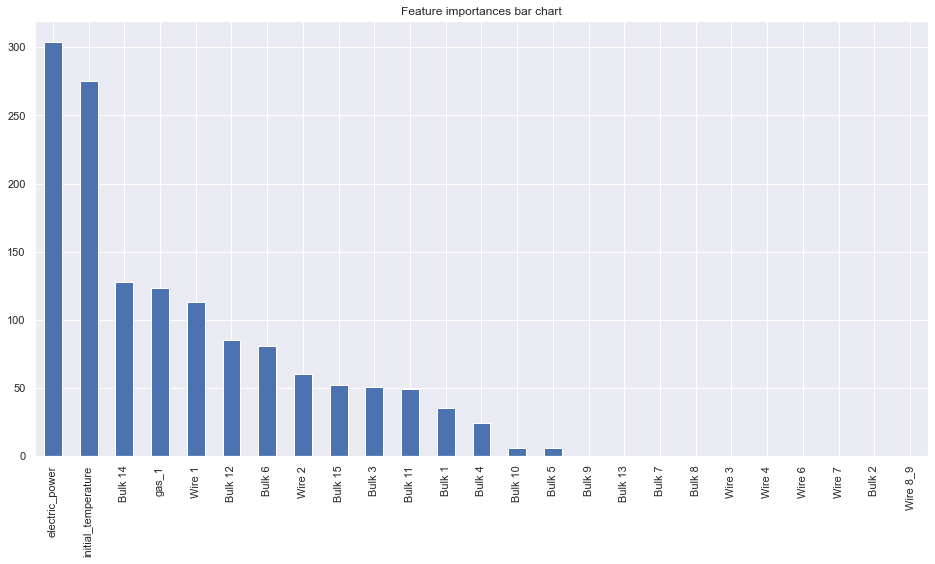

In [54]:
importance(model_gb)

In [55]:
importance = model_gb.feature_importances_
colums_features = features.columns 
importance = pd.Series(importance, index=colums_features) 
display(importance.sort_values(ascending=False))

electric_power         304
initial_temperature    275
Bulk 14                128
gas_1                  123
Wire 1                 113
Bulk 12                 85
Bulk 6                  81
Wire 2                  60
Bulk 15                 52
Bulk 3                  51
Bulk 11                 49
Bulk 1                  35
Bulk 4                  24
Bulk 10                  6
Bulk 5                   6
Bulk 9                   0
Bulk 13                  0
Bulk 7                   0
Bulk 8                   0
Wire 3                   0
Wire 4                   0
Wire 6                   0
Wire 7                   0
Bulk 2                   0
Wire 8_9                 0
dtype: int32

We see that the features *Wire 3*, *Wire 6*, *Wire 4*, *Wire 7*, *Bulk 13*, *Bulk 2*, *Bulk 13*, *Bulk 9*, *Bulk 8*, *Bulk 7*, *Wire 8_9* have no effect on the target feature at all. Whereas *Wire 1*, *electric_power*, *initial_temperature*, and *Bulk 12* significantly affect steel temperature. This information should be passed on to the customer.

## 10. Sanity check

In [56]:
# Let's check the model for sanity.
dummy_model = DummyRegressor()
dummy_model.fit(features_train, target_train)
predictions_dummy = pd.Series(
    dummy_model.predict(features_test), 
    index=target_test.index
    )
mae_dummy = mean_absolute_error(target_test, predictions_dummy)
print(f'Dummy model MAE is {mae_dummy:.1f}')
if mae_dummy < mae_gb:
    print('Our model is insane. Improvement is required.')
else:
    print('Our model is sane.')

Dummy model MAE is 7.8
Our model is sane.


## 11. General conclusion

Let's recap the completed tasks.
While working on a project, we:
1. Loaded the data and examined it
2. We did an exploratory data analysis, during which we examined each dataset in detail, processed missing values, outliers (requires agreement with the customer), anomalies. Conducted data grouping. Defined the target feature.
3. Prepared data for modeling. Merged tables into one base dataset.
4. Prepared sets of features: target (Temperature) and the rest.
5. We checked the features for multicollinearity. Studied correlation. Brought multicollinearity to acceptable limits.
6. We split the dataset into training and test sets.
7. Created a gradient boosting model Light GBM. Hyperparameters were selected using cross-validation.
8. Tested the model. The MAE of our model was 5.5.
9. We analyzed the importance of features in the model. Prepared a list of features that do not affect the target feature. The most important factors of influence on the target attribute were determined.
10. Checked the model for sanity. The model is sane.

During the work, the following difficulties arose:
* I had to make a difficult decision to remove the feature *Temperature* from the outlier dataset. It made the model more artificial than it could be. There were, of course, obvious outliers - values below the melting point. The rest of the emissions were quite real and physically conditioned. However, I decided to remove them in order to achieve the highest possible MAE metric.
* Initially, I used the CatBoost library. With its help, it was possible to achieve a MAE value of 5.7 on the training sample. Unfortunately, this was achieved due to a large number of iterations (about 1000), and, as a result, the model was overfitted. The MAE value on the test sample was catastrophic - about 30. To get rid of overfitting, I reconfigured the hyperparameters. Reduced the number of iterations to 40-50, reduced the maximum depth of the tree, changed the learning rate. The MAE of the test set has decreased, but not enough. Then I decided to use Light GBM, a library that is famous for its success in solving the regression problem. It showed the best results.

The key steps in solving the problem were:
* Data processing. Removal of outliers and anomalies, processing of passes.
* Definition of the target feature. We have determined exactly what temperature should be the target feature. It is the one that was measured last (as the last operation).
* Correct merging of tables, grouping values by batches.
* Competent feature engineering.
* Checking features for multicollinearity.
* Correct fitting of model hyperparameters.

In [57]:
model_gb.get_params

<bound method LGBMModel.get_params of LGBMRegressor(learning_rate=0.05, max_depth=5, n_estimators=160, num_leaves=10,
              random_state=12345)>

Our model parameters: Light GBM Regressor. LGBMRegressor(max_depth=5, n_estimators=160, num_leaves=10, random_state=12345, learning_rate=0.05)